MinMax

In [1]:
# Base Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import time
from collections import defaultdict

# Data Analysis Libraries
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE, SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
csv_file = 'CICDDoS-Real/cicddos2019_cleaned.csv'
df = pd.read_csv(csv_file, low_memory=False)
df.shape

(360000, 88)

In [3]:
# Mengacak seluruh baris DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### Informasi Dataset

In [7]:
#info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Protocol                     360000 non-null  int64  
 2   Flow Duration                360000 non-null  int64  
 3   Total Fwd Packets            360000 non-null  int64  
 4   Total Backward Packets       360000 non-null  int64  
 5   Total Length of Fwd Packets  360000 non-null  float64
 6   Total Length of Bwd Packets  360000 non-null  float64
 7   Fwd Packet Length Max        360000 non-null  float64
 8   Fwd Packet Length Min        360000 non-null  float64
 9   Fwd Packet Length Mean       360000 non-null  float64
 10  Fwd Packet Length Std        360000 non-null  float64
 11  Bwd Packet Length Max        360000 non-null  float64
 12  Bwd Packet Length Min        360000 non-null  float64
 13 

In [8]:
#Bagian awal dataset
df.head()

,Unnamed: 0,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,28102,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
1,17675,17,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
2,661545,6,1,2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9
3,688385,6,51,2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9
4,16016,17,105961,4,0,1438.0,0.0,389.0,330.0,359.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8


In [9]:
df.describe()

,Unnamed: 0,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
count,360000.000000,360000.000000,3.600000e+05,360000.000000,360000.000000,3.600000e+05,3.600000e+05,360000.000000,360000.000000,360000.000000,...,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,360000.000000,360000.000000
mean,91493.758128,14.700269,2.200160e+06,8.975250,0.585044,3.733058e+03,3.847677e+02,582.758328,560.433108,570.884243,...,7.325171e+03,2.620700e+03,1.084865e+04,5.733338e+03,6.801519e+05,1.105356e+05,8.047233e+05,5.820746e+05,0.930525,5.500000
std,135889.709116,4.502866,1.275317e+07,250.280517,12.328315,3.287519e+04,3.131816e+04,544.547707,543.747646,538.238212,...,1.685573e+05,7.402011e+04,2.224704e+05,1.570655e+05,4.457633e+06,1.025535e+06,5.103451e+06,4.112389e+06,0.254261,3.452057
min,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,11986.000000,17.000000,1.000000e+00,2.000000,0.000000,4.580000e+02,0.000000e+00,229.000000,152.000000,229.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,2.750000
50%,38063.500000,17.000000,2.000000e+00,2.000000,0.000000,1.088000e+03,0.000000e+00,415.000000,383.000000,401.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,5.500000
75%,106306.000000,17.000000,1.821250e+03,4.000000,0.000000,2.944000e+03,0.000000e+00,1035.000000,882.000000,882.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,8.250000
max,805151.000000,17.000000,1.200000e+08,86220.000000,4602.000000,1.526642e+07,8.818824e+06,32120.000000,2020.000000,3015.290539,...,1.721058e+07,2.284064e+07,4.358468e+07,1.310114e+07,1.058368e+08,6.600292e+07,1.058368e+08,1.058368e+08,1.000000,11.000000


In [10]:
df['Label'].value_counts()

Label
2     30000
9     30000
8     30000
5     30000
3     30000
1     30000
7     30000
6     30000
4     30000
10    30000
11    30000
0     30000
Name: count, dtype: int64

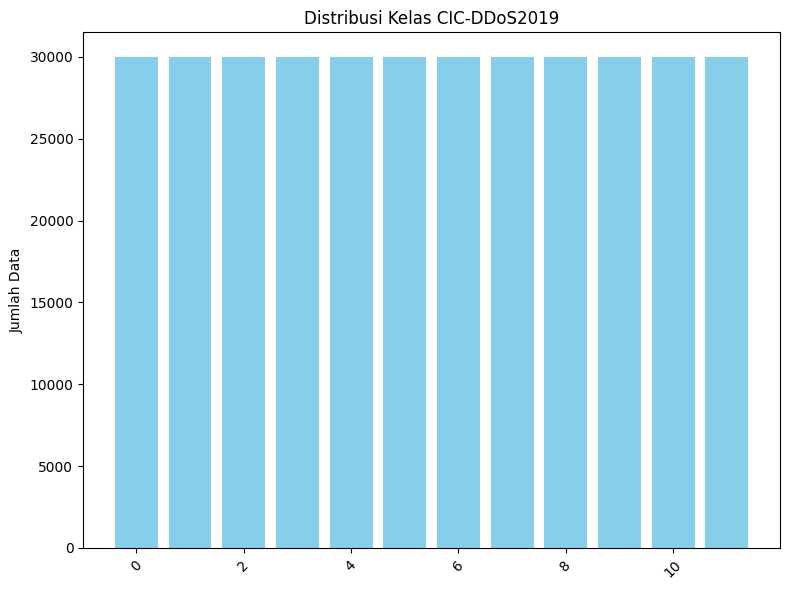

In [11]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Kelas CIC-DDoS2019')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

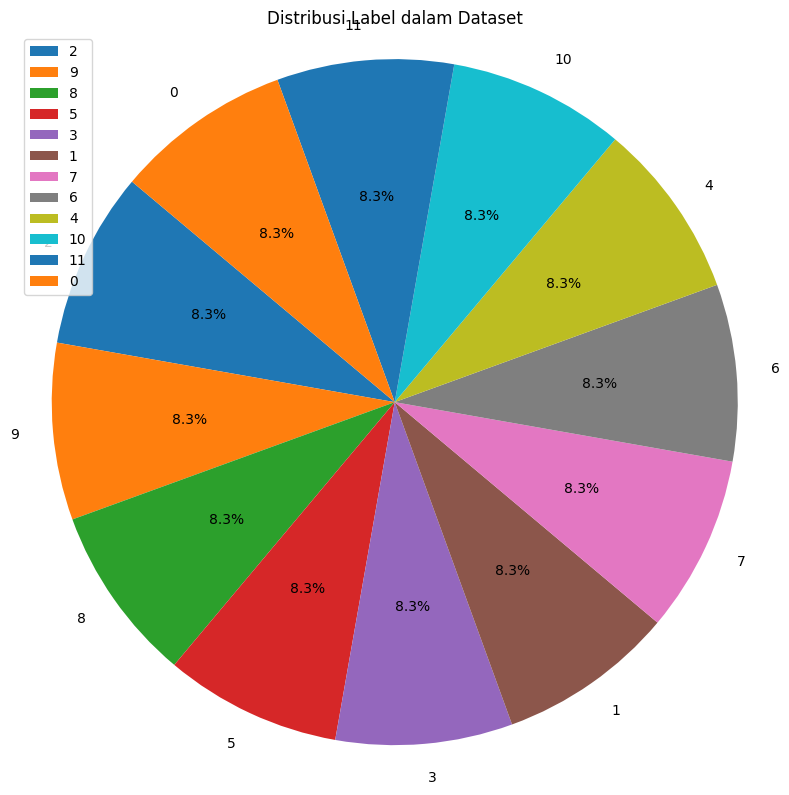

In [12]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.legend()
plt.title('Distribusi Label dalam Dataset')
plt.axis('equal')  # Agar bentuk pie-nya bulat
plt.tight_layout()
plt.show()

In [13]:
# Menampilkan jumlah sample tiap protocol. '17' = UDP. '6' = TCP. '0' = HOPOPT (IPv6 Hop-by-Hop Option)
df['Protocol'].value_counts()

Protocol
17    285251
6      73805
0        944
Name: count, dtype: int64

### Drop and Encoding Label

In [14]:
df = df.drop(['Flow ID', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Timestamp', 'SimillarHTTP', 'Fwd Header Length.1'], axis=1)
df.info()

KeyError: "['Flow ID', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Timestamp', 'SimillarHTTP', 'Fwd Header Length.1'] not found in axis"

In [ ]:
# Pengubahan nilai dari string (kategorikal) ke numerik
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

label_mapping = pd.DataFrame({
    'Original Label': le.classes_,
    'Encoded Value': range(len(le.classes_))
})

print("Mapping of original labels to encoded values:")
print(label_mapping)

Mapping of original labels to encoded values:
   Original Label  Encoded Value
0          BENIGN              0
1       DrDoS_DNS              1
2      DrDoS_LDAP              2
3     DrDoS_MSSQL              3
4       DrDoS_NTP              4
5   DrDoS_NetBIOS              5
6      DrDoS_SNMP              6
7      DrDoS_SSDP              7
8       DrDoS_UDP              8
9             Syn              9
10           TFTP             10
11        UDP-lag             11


In [ ]:
# Menampilkan sampel data setelah encoding (sudah bernilai numerikal)
df.loc[:,['Label']].head()

,Label
0,2
1,2
2,9
3,9
4,8


### X dan Y

In [15]:
X = df.drop(['Label'], axis=1)
y = df['Label']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Modeling without Feature Selection -- MinMaxScaler

#### MinMaxScaler

In [17]:
categorical_features = ['Protocol', 'Inbound']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Buat transformer untuk masing-masing tipe fitur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),   # Standarisasi untuk fitur numerik
        ('cat', 'passthrough', categorical_features)     # Lewatkan fitur kategori tanpa diubah
    ])

# Fit dan transform sekaligus
X_train_scaled_minmax = preprocessor.fit_transform(X_train)
X_test_scaled_minmax = preprocessor.transform(X_test)

In [18]:
def evaluate_model(model, X_test, y_test, name="Model"):
    # Waktu prediksi
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred
    print(f"Waktu prediksi ({name}): {prediction_time:.4f} detik")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Classification report
    print(classification_report(y_test, y_pred, zero_division=0))

#### Algoritma Individual MinMaxScaler

##### MLP

Iteration 1, loss = 1.19271738
Iteration 2, loss = 0.78884713
Iteration 3, loss = 0.69205089
Iteration 4, loss = 0.65052104
Iteration 5, loss = 0.62723739
Iteration 6, loss = 0.61211305
Iteration 7, loss = 0.59977552
Iteration 8, loss = 0.59097256
Iteration 9, loss = 0.58450047
Iteration 10, loss = 0.57803289
Iteration 11, loss = 0.57175631
Iteration 12, loss = 0.56801178
Iteration 13, loss = 0.56411535
Iteration 14, loss = 0.56034758
Iteration 15, loss = 0.55758148
Iteration 16, loss = 0.55480634
Iteration 17, loss = 0.55281024
Iteration 18, loss = 0.55064062
Iteration 19, loss = 0.54856896
Iteration 20, loss = 0.54748950
Iteration 21, loss = 0.54523213
Iteration 22, loss = 0.54431406
Iteration 23, loss = 0.54324520
Iteration 24, loss = 0.54175122
Iteration 25, loss = 0.54082854
Iteration 26, loss = 0.53960678
Iteration 27, loss = 0.53856788
Iteration 28, loss = 0.53663358
Iteration 29, loss = 0.53565884
Iteration 30, loss = 0.53449982
Iteration 31, loss = 0.53345980
Iteration 32, los

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Waktu prediksi (MLP Classifier - MinMax): 0.7696 detik


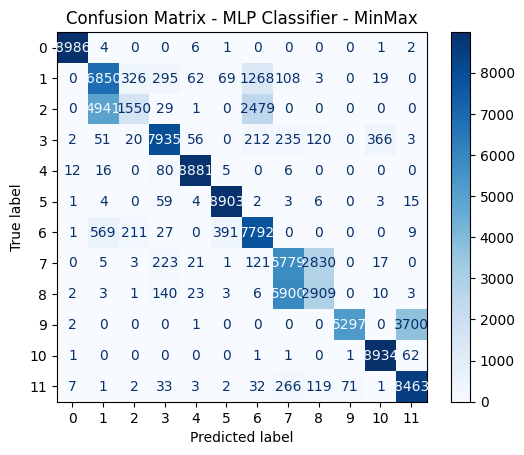

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.55      0.76      0.64      9000
           2       0.73      0.17      0.28      9000
           3       0.90      0.88      0.89      9000
           4       0.98      0.99      0.98      9000
           5       0.95      0.99      0.97      9000
           6       0.65      0.87      0.75      9000
           7       0.47      0.64      0.54      9000
           8       0.49      0.32      0.39      9000
           9       0.99      0.59      0.74      9000
          10       0.96      0.99      0.97      9000
          11       0.69      0.94      0.80      9000

    accuracy                           0.76    108000
   macro avg       0.78      0.76      0.75    108000
weighted avg       0.78      0.76      0.75    108000



In [20]:
# MLPClassifier
start_train = time.time()

mlp = MLPClassifier(random_state=42, verbose=True)

mlp.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (MLP Classifier): {training_time:.4f} detik")

evaluate_model(mlp, X_test_scaled_minmax, y_test, name="MLP Classifier - MinMax")

Iteration 1, loss = 0.87710722
Validation score: 0.704405
Iteration 2, loss = 0.60530411
Validation score: 0.718333
Iteration 3, loss = 0.56724987
Validation score: 0.746071
Iteration 4, loss = 0.55298981
Validation score: 0.742024
Iteration 5, loss = 0.54200680
Validation score: 0.731429
Iteration 6, loss = 0.53462826
Validation score: 0.746230
Iteration 7, loss = 0.52601545
Validation score: 0.746905
Iteration 8, loss = 0.52245437
Validation score: 0.756508
Iteration 9, loss = 0.51526739
Validation score: 0.747421
Iteration 10, loss = 0.51180282
Validation score: 0.756786
Iteration 11, loss = 0.50863760
Validation score: 0.749167
Iteration 12, loss = 0.50397915
Validation score: 0.752341
Iteration 13, loss = 0.50423741
Validation score: 0.748651
Iteration 14, loss = 0.49985816
Validation score: 0.752857
Iteration 15, loss = 0.49980483
Validation score: 0.759960
Iteration 16, loss = 0.49543161
Validation score: 0.756587
Iteration 17, loss = 0.49421407
Validation score: 0.751349
Iterat

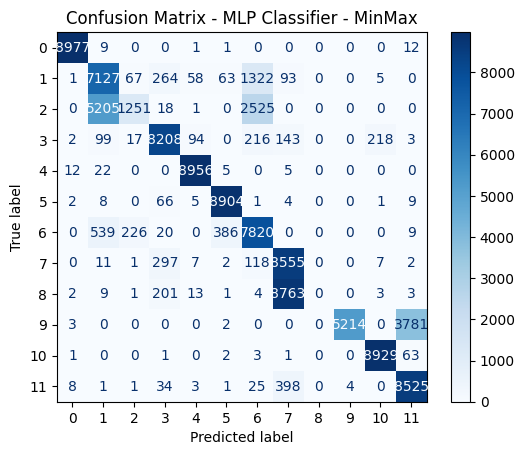

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.55      0.79      0.65      9000
           2       0.80      0.14      0.24      9000
           3       0.90      0.91      0.91      9000
           4       0.98      1.00      0.99      9000
           5       0.95      0.99      0.97      9000
           6       0.65      0.87      0.74      9000
           7       0.48      0.95      0.63      9000
           8       0.00      0.00      0.00      9000
           9       1.00      0.58      0.73      9000
          10       0.97      0.99      0.98      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.76    108000
   macro avg       0.75      0.76      0.72    108000
weighted avg       0.75      0.76      0.72    108000



In [54]:
# MLPClassifier
start_train = time.time()

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42,
    verbose=True
)

mlp.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (MLP Classifier): {training_time:.4f} detik")

evaluate_model(mlp, X_test_scaled_minmax, y_test, name="MLP Classifier - MinMax")

##### KNN

Waktu pelatihan (KNN): 0.0583 detik
Waktu prediksi (KNN -- MinMax): 24.4578 detik


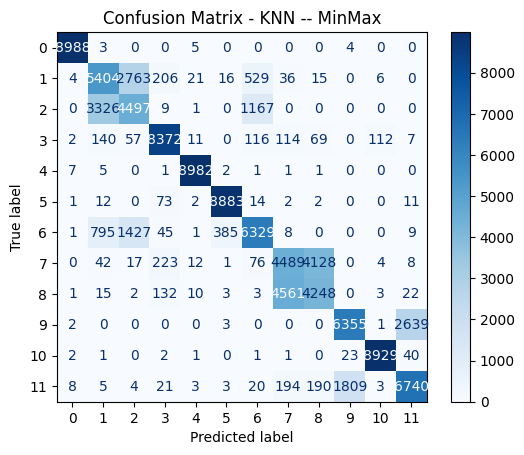

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.55      0.60      0.58      9000
           2       0.51      0.50      0.51      9000
           3       0.92      0.93      0.93      9000
           4       0.99      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.77      0.70      0.73      9000
           7       0.48      0.50      0.49      9000
           8       0.49      0.47      0.48      9000
           9       0.78      0.71      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.71      0.75      0.73      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [21]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier()
knn.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test_scaled_minmax, y_test, name="KNN -- MinMax")

Waktu pelatihan (KNN): 0.0655 detik
Waktu prediksi (KNN -- MinMax): 24.4676 detik


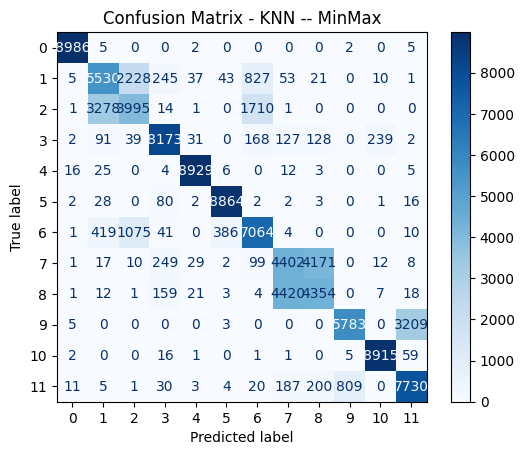

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9000
           1       0.59      0.61      0.60      9000
           2       0.54      0.44      0.49      9000
           3       0.91      0.91      0.91      9000
           4       0.99      0.99      0.99      9000
           5       0.95      0.98      0.97      9000
           6       0.71      0.78      0.75      9000
           7       0.48      0.49      0.48      9000
           8       0.49      0.48      0.49      9000
           9       0.88      0.64      0.74      9000
          10       0.97      0.99      0.98      9000
          11       0.70      0.86      0.77      9000

    accuracy                           0.77    108000
   macro avg       0.77      0.77      0.76    108000
weighted avg       0.77      0.77      0.76    108000



In [55]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test_scaled_minmax, y_test, name="KNN -- MinMax")

##### RF

Waktu pelatihan (Random Forest): 49.4802 detik
Waktu prediksi (Random Forest -- MinMax): 2.7156 detik


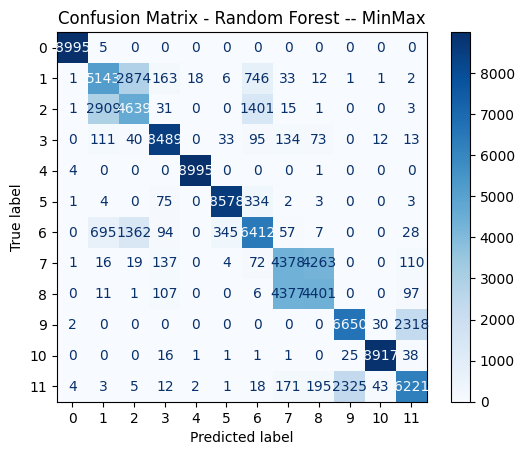

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.58      0.57      0.57      9000
           2       0.52      0.52      0.52      9000
           3       0.93      0.94      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.95      0.95      9000
           6       0.71      0.71      0.71      9000
           7       0.48      0.49      0.48      9000
           8       0.49      0.49      0.49      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.70      0.69      0.70      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [56]:
# Random Forest
start_train = time.time()

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Random Forest): {training_time:.4f} detik")

evaluate_model(rf, X_test_scaled_minmax, y_test, name="Random Forest -- MinMax")

##### LR

Waktu pelatihan (Logistic Regression): 446.5821 detik
Waktu prediksi (Logistic Regression -- MinMaxScaler): 0.0299 detik


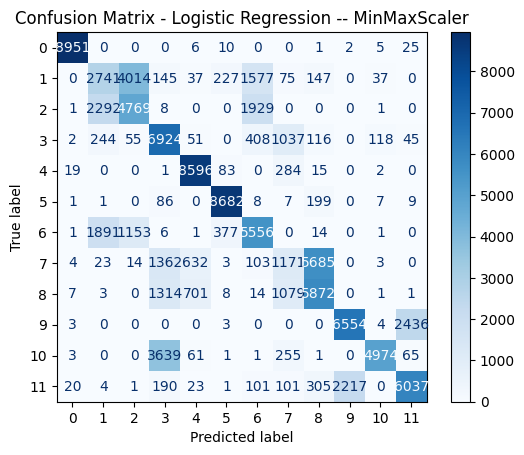

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9000
           1       0.38      0.30      0.34      9000
           2       0.48      0.53      0.50      9000
           3       0.51      0.77      0.61      9000
           4       0.85      0.96      0.90      9000
           5       0.92      0.96      0.94      9000
           6       0.57      0.62      0.59      9000
           7       0.29      0.13      0.18      9000
           8       0.48      0.65      0.55      9000
           9       0.75      0.73      0.74      9000
          10       0.97      0.55      0.70      9000
          11       0.70      0.67      0.69      9000

    accuracy                           0.66    108000
   macro avg       0.66      0.66      0.64    108000
weighted avg       0.66      0.66      0.64    108000



In [61]:
# Logistic Regression
start_train = time.time()

logreg = LogisticRegression(max_iter=5000, solver='lbfgs')
logreg.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Logistic Regression): {training_time:.4f} detik")

evaluate_model(logreg, X_test_scaled_minmax, y_test, name="Logistic Regression -- MinMaxScaler")

##### XGB

Waktu pelatihan (XGBoost): 8.9236 detik
Waktu prediksi (XGBoost -- MinMaxScaler): 0.2033 detik


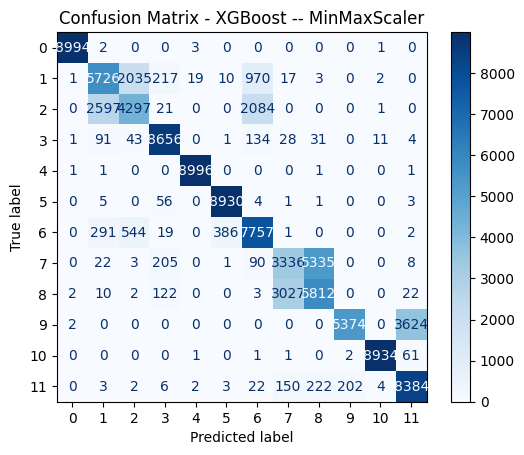

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.65      0.64      0.65      9000
           2       0.62      0.48      0.54      9000
           3       0.93      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.86      0.77      9000
           7       0.51      0.37      0.43      9000
           8       0.51      0.65      0.57      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.79    108000
   macro avg       0.79      0.79      0.78    108000
weighted avg       0.79      0.79      0.78    108000



In [57]:
# XGBoost
start_train = time.time()

xgBoost = xgb.XGBClassifier(tree_method="hist")
xgBoost.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (XGBoost): {training_time:.4f} detik")

evaluate_model(xgBoost, X_test_scaled_minmax, y_test, name="XGBoost -- MinMaxScaler")

##### SVM

Waktu pelatihan (SVM): 3845.1026 detik
Waktu prediksi (SVM -- MinMaxScaler): 2127.4933 detik


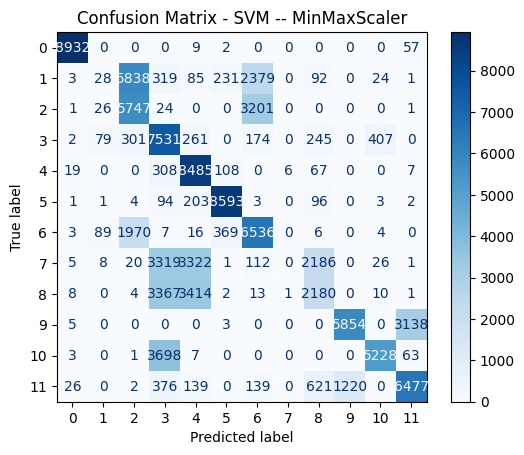

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9000
           1       0.12      0.00      0.01      9000
           2       0.41      0.64      0.50      9000
           3       0.40      0.84      0.54      9000
           4       0.53      0.94      0.68      9000
           5       0.92      0.95      0.94      9000
           6       0.52      0.73      0.61      9000
           7       0.00      0.00      0.00      9000
           8       0.40      0.24      0.30      9000
           9       0.83      0.65      0.73      9000
          10       0.92      0.58      0.71      9000
          11       0.66      0.72      0.69      9000

    accuracy                           0.61    108000
   macro avg       0.56      0.61      0.56    108000
weighted avg       0.56      0.61      0.56    108000



In [19]:
# SVM
start_train = time.time()

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model(svm, X_test_scaled_minmax, y_test, name="SVM -- MinMaxScaler")

##### GBC

Waktu pelatihan (Gradient Boosting): 867.7502 detik
Waktu prediksi (Gradient Boosting -- MinMaxScaler): 2.7949 detik


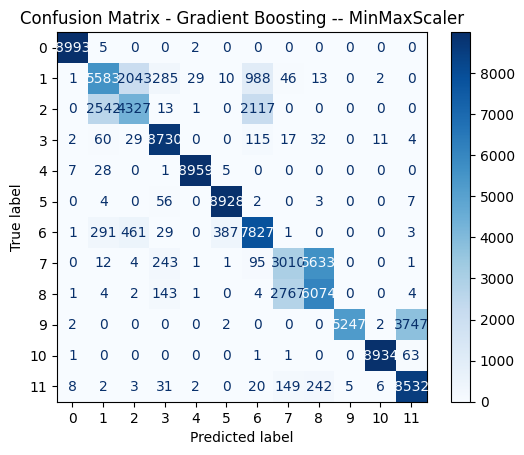

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.65      0.62      0.64      9000
           2       0.63      0.48      0.55      9000
           3       0.92      0.97      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.70      0.87      0.78      9000
           7       0.50      0.33      0.40      9000
           8       0.51      0.67      0.58      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.79    108000
   macro avg       0.80      0.79      0.78    108000
weighted avg       0.80      0.79      0.78    108000



In [63]:
# GBC
start_train = time.time()

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Gradient Boosting): {training_time:.4f} detik")

evaluate_model(gbc, X_test_scaled_minmax, y_test, name="Gradient Boosting -- MinMaxScaler")

##### NB

Waktu pelatihan (Naive Bayes): 0.3266 detik
Waktu prediksi (Naive Bayes -- MinMaxScaler): 0.6751 detik


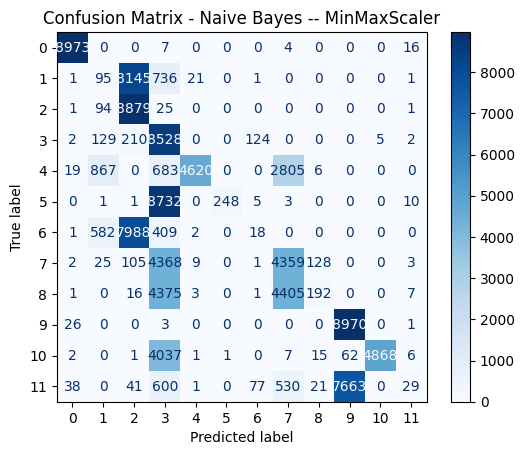

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9000
           1       0.05      0.01      0.02      9000
           2       0.35      0.99      0.52      9000
           3       0.26      0.95      0.41      9000
           4       0.99      0.51      0.68      9000
           5       1.00      0.03      0.05      9000
           6       0.08      0.00      0.00      9000
           7       0.36      0.48      0.41      9000
           8       0.53      0.02      0.04      9000
           9       0.54      1.00      0.70      9000
          10       1.00      0.54      0.70      9000
          11       0.38      0.00      0.01      9000

    accuracy                           0.46    108000
   macro avg       0.54      0.46      0.38    108000
weighted avg       0.54      0.46      0.38    108000



In [58]:
# Naive Bayes
start_train = time.time()

nb = GaussianNB()
nb.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Naive Bayes): {training_time:.4f} detik")

evaluate_model(nb, X_test_scaled_minmax, y_test, name="Naive Bayes -- MinMaxScaler")

##### DT

Waktu pelatihan (Decision Tree): 4.3898 detik
Waktu prediksi (Decision Tree -- MinMaxScaler): 0.0446 detik


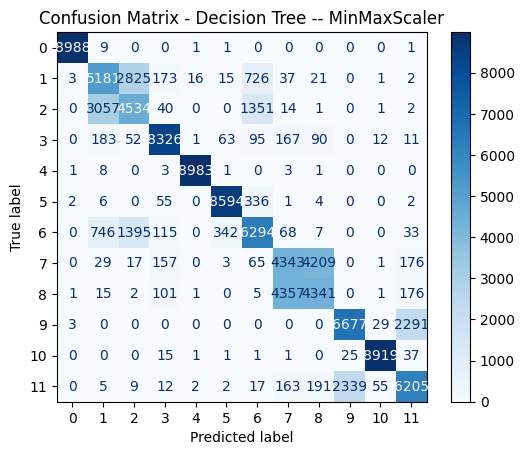

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.56      0.58      0.57      9000
           2       0.51      0.50      0.51      9000
           3       0.93      0.93      0.93      9000
           4       1.00      1.00      1.00      9000
           5       0.95      0.95      0.95      9000
           6       0.71      0.70      0.70      9000
           7       0.47      0.48      0.48      9000
           8       0.49      0.48      0.49      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.69      0.69      0.69      9000

    accuracy                           0.75    108000
   macro avg       0.75      0.75      0.75    108000
weighted avg       0.75      0.75      0.75    108000



In [59]:
# Decision Tree
start_train = time.time()

dt = DecisionTreeClassifier()
dt = dt.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Decision Tree): {training_time:.4f} detik")

evaluate_model(dt, X_test_scaled_minmax, y_test, name="Decision Tree -- MinMaxScaler")

##### Adaboost

Waktu pelatihan (AdaBoost): 19.5660 detik
Waktu prediksi (AdaBoost Classifier -- MinMaxScaler): 1.2080 detik


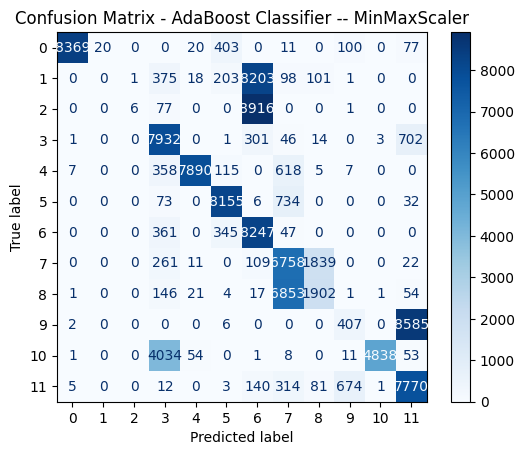

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9000
           1       0.00      0.00      0.00      9000
           2       0.86      0.00      0.00      9000
           3       0.58      0.88      0.70      9000
           4       0.98      0.88      0.93      9000
           5       0.88      0.91      0.89      9000
           6       0.32      0.92      0.47      9000
           7       0.44      0.75      0.55      9000
           8       0.48      0.21      0.29      9000
           9       0.34      0.05      0.08      9000
          10       1.00      0.54      0.70      9000
          11       0.45      0.86      0.59      9000

    accuracy                           0.58    108000
   macro avg       0.61      0.58      0.51    108000
weighted avg       0.61      0.58      0.51    108000



In [60]:
# AdaBoost
start_train = time.time()

adc = AdaBoostClassifier(random_state=42)
adc.fit(X_train_scaled_minmax, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (AdaBoost): {training_time:.4f} detik")

evaluate_model(adc, X_test_scaled_minmax, y_test, name="AdaBoost Classifier -- MinMaxScaler")